# 1. Setup

In [1]:
from time import time

import plotly.express as px
from pqdm.processes import pqdm
from scipy.optimize import curve_fit
from lightgbm import LGBMRegressor
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, make_scorer)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor

from utils import *

# 2. Prepare data

## 2.1. Trips

In [2]:
trips = pd.read_parquet(DATA / 'trips.parquet').disp()

747,088 rows x 21 cols; Memory: 34.9 MiB


,Distance,Time,Speed,Weight,Purpose,Mode,Weekend,GasPrice,StayTime,StartTime,...,MSAKind,Age,Sex,Race,Hispanic,Education,Worker,Income,HomeOwn,VehOwn
,<float64>,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>,<category>,...,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>,<category>
0,8.439379,16.182075,31.291583,0.5,HBO,Drive,No,Low,Long,Off-peak,...,Small,Senior,Female,Non-White,No,College,No,Mid,Own,High


In [3]:
factors = list(trips.select_dtypes(CAT).columns)

## 2.2. Dataset for modeling

In [4]:
X = pd.get_dummies(trips[factors]).disp(0)

747,088 rows x 51 cols; Memory: 36.3 MiB


,Purpose_HBW,Purpose_HBSHOP,Purpose_HBSOC,Purpose_HBO,Purpose_NHB,Mode_Drive,Mode_Transit,Mode_Walk,Mode_Bike,Weekend_Yes,...,Education_College,Worker_Yes,Worker_No,Income_Low,Income_Mid,Income_High,HomeOwn_Own,HomeOwn_Rent,VehOwn_Low,VehOwn_High
,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,...,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>,<bool>


In [5]:
# Y = trips[['Distance', 'Time']]
Y = pd.concat([np.log(1 + trips[x]).rename(x) 
               for x in ['Distance', 'Time']], axis=1)

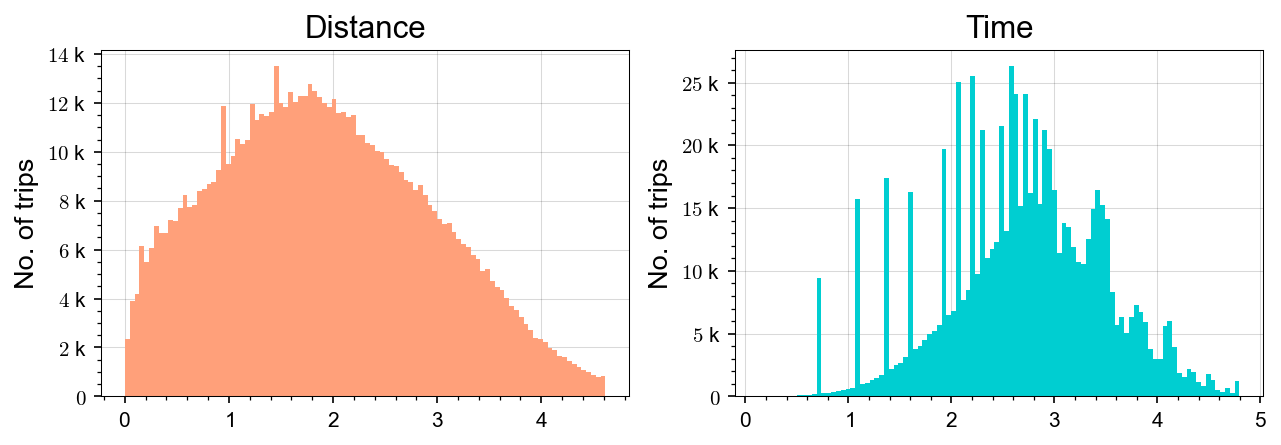

In [6]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
for ax, trg, color in zip(axes, Y.columns, ['lightsalmon', 'darkturquoise']):
    ax = pplot(ax, title=trg, yeng=1, ylab='No. of trips')
    Y[trg].hist(bins=100, ax=ax, color=color)

In [7]:
train_ratio, val_ratio = 0.7, 0.15
np.random.seed(SEED)
np.random.shuffle(X.index.values)
splits = np.split(X.index, [int(x * len(X)) for x in [
    train_ratio, train_ratio + val_ratio, 1]])
idx = D(zip(['train', 'val', 'test'], splits[:-1]))
for k, v in idx.items():
    print(f'{k.upper()}: {len(v):,}')

TRAIN: 522,961
VAL: 112,063
TEST: 112,064


# 3. Modeling

In [8]:
metrics = D(r2=r2_score, mae=mean_absolute_error, 
            mape=mean_absolute_percentage_error, mse=mean_squared_error)

## 3.1. Test models

In [9]:
test_models = (
    ## Linear models
    ('Linear Regression', LinearRegression(), D(
        fit_intercept=[True, False],
    )),
    ('Bayesian Ridge', BayesianRidge(max_iter=1000), D(
        alpha_1=[.5e-6, 1e-6, 2e-6],
        alpha_2=[.5e-6, 1e-6, 2e-6],
        lambda_1=[.5e-6, 1e-6, 2e-6],
        lambda_2=[.5e-6, 1e-6, 2e-6],
    )),
    ('SGD Regression', SGDRegressor(max_iter=1000), D(
        alpha=[1e-05, 0.0001, 0.001, 0.01],
        l1_ratio=[0.1, 0.15, 0.2, 0.3],
        penalty=['l2', 'elasticnet'],
    )),
    ('Linear SVR', LinearSVR(dual='auto', max_iter=50_000), D(
        C=[0.5, 0.75, 1.0, 1.25, 1.5],
        epsilon=[0, 0.1, 0.2],
        loss=['epsilon_insensitive', 'squared_epsilon_insensitive']
    )),
    ## Decision tree models
    ('Random Forest', RandomForestRegressor(n_jobs=4), D(
       n_estimators=[100, 200, 500, 750],
       max_depth=[10, 20, 30, 40],
    )),
    ('Light Gradient Boost', LGBMRegressor(
        n_jobs=4, force_row_wise=True, num_leaves=1000, verbosity=-1), D(
            learning_rate=[0.05, 0.1, 0.5],
            max_depth=[10, 20, 30, 40],
            n_estimators=[100, 200, 500, 750],
    )),
    ('Extreme Gradient Boost', XGBRegressor(n_jobs=4, verbosity=0), D(
        booster=['gbtree', 'gblinear'],
        learning_rate=[0.05, 0.1, 0.5],
        n_estimators=[100, 200, 500, 750],
    )),
)

## 3.2. Cross validate for hyperparameter tuning

In [26]:
def cross_validate(X=X, Y=Y, idx=idx, models=test_models, metrics=metrics,
                   njobs=1, overwrite=False):
    od = '_odurban' if any(['ODUrban' in x for x in X.columns]) else ''
    outpath = DATA / f'models/cv{od}_{len(idx["val"])/1e3:.0f}k.pickle'
    if outpath.exists() and not overwrite:
        return pd.read_pickle(outpath)
    res = []
    for target in Y.columns:
        Xval, yval = X.loc[idx['val']], Y.loc[idx['val'], target]
        Xtest, ytest = X.loc[idx['test']], Y.loc[idx['test'], target]
        pbar = tqdm(models)
        for name, model, params in pbar:
            pbar.set_description(name)
            cv = GridSearchCV(model, params, cv=2, n_jobs=njobs, scoring='r2')
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                cv.fit(Xval, yval)
            row = D(target=target, model=name, params=cv.best_params_,
                    estimator=cv.best_estimator_)
            ypred = cv.best_estimator_.predict(Xtest)
            for metric, func in metrics.items():
                row[metric] = func(ytest, ypred)
            res.append(row)
    res = Pdf(res)
    res.to_pickle(mkfile(outpath))
    return res

cv = cross_validate(njobs=12, overwrite=0).disp() # t=9:38

14 rows x 8 cols; Memory: 0.0 MiB


,target,model,params,estimator,r2,mae,mape,mse
,<object>,<object>,<object>,<object>,<float64>,<float64>,<float64>,<float64>
0,Distance,Linear Regression,{'fit_intercept': False},LinearRegression(fit_intercept=False),0.347677,0.657447,0.867719,0.682578


In [27]:
(cv.drop(columns=['params', 'estimator'])
 .assign(model=lambda df: ordered_factor(df.model))
 .melt(['target', 'model'], var_name='metric')
 .pivot_table('value', 'model', ['target', 'metric']))

target                  Distance                                    Time  \
metric                       mae      mape       mse        r2       mae   
model                                                                      
Linear Regression       0.657447  0.867719  0.682578  0.347677  0.565697   
Bayesian Ridge          0.657440  0.867817  0.682572  0.347683  0.565698   
SGD Regression          0.665407  0.923430  0.689433  0.341126  0.565619   
Linear SVR              0.657410  0.867260  0.682556  0.347698  0.565697   
Random Forest           0.648136  0.844643  0.671188  0.358563  0.557485   
Light Gradient Boost    0.641828  0.840010  0.660206  0.369058  0.553669   
Extreme Gradient Boost  0.641429  0.838047  0.658487  0.370701  0.553036   

target                                                
metric                      mape       mse        r2  
model                                                 
Linear Regression       0.270526  0.515815  0.146888  
Bayesian Ridge          0.270568  0.515816  0.146887  
SGD Regression          0.272351  0.516202  0.146248  
Linear SVR              0.270545  0.515814  0.146891  
Random Forest           0.266573  0.503323  0.167549  
Light Gradient Boost    0.264386  0.496414  0.178976  
Extreme Gradient Boost  0.264356  0.494892  0.181493

# 4. SHAP analysis

## 4.1. Compute SHAP values

In [30]:
def get_shaps(cv=cv, model='Extreme Gradient Boost',
              X=X, seed=SEED, overwrite=False):
    outpath = DATA / 'models/shaps.parquet'
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    for target in tqdm(['Distance', 'Time']):
        row = cv.query(f'model=="{model}" & target=="{target}"').iloc[0]
        explainer = shap.TreeExplainer(row.estimator, seed=seed)
        shaps = explainer(X).values
        df = Pdf(shaps, columns=X.columns).astype(np.float32)
        df.insert(0, 'Target', target)
        res.append(df)
    df = pd.concat(res).astype(D(Target=CAT))
    df.to_parquet(mkfile(outpath))
    return df

shaps = get_shaps(overwrite=0).disp() # t=19:09

1,494,176 rows x 52 cols; Memory: 303.5 MiB


,Target,Purpose_HBW,Purpose_HBSHOP,Purpose_HBSOC,Purpose_HBO,Purpose_NHB,Mode_Drive,Mode_Transit,Mode_Walk,Mode_Bike,...,Education_College,Worker_Yes,Worker_No,Income_Low,Income_Mid,Income_High,HomeOwn_Own,HomeOwn_Rent,VehOwn_Low,VehOwn_High
,<category>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,Distance,-0.050977,0.012705,-0.008256,0.036506,0.052175,0.003061,-0.003754,0.109814,0.004128,...,0.0,-0.014409,0.0,0.030237,0.001271,-0.01545,0.013875,0.0,0.002138,0.0


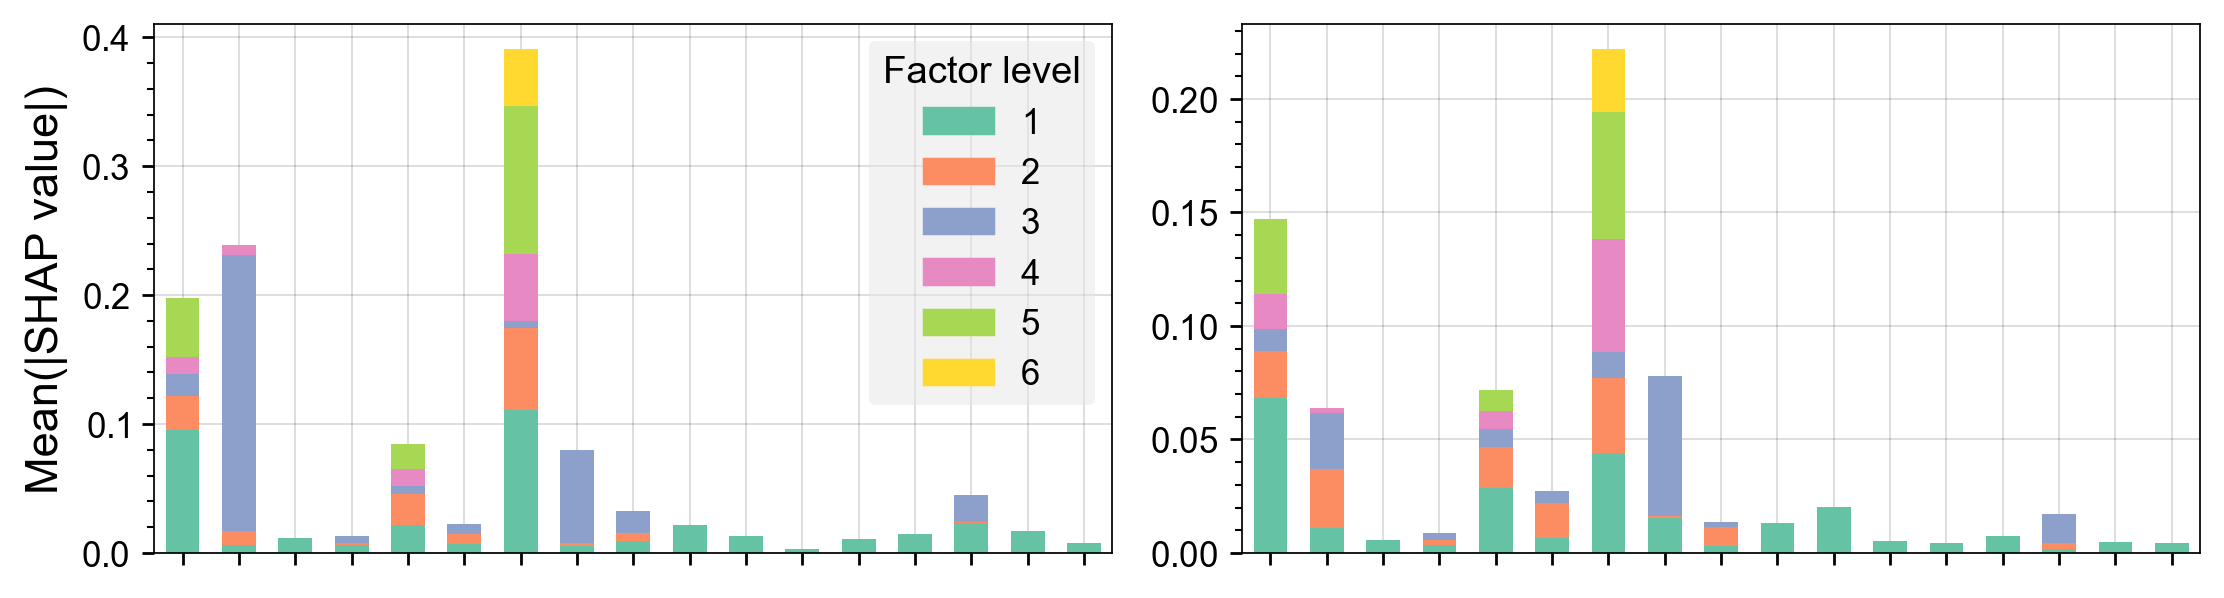

In [31]:
def fig_shap_contrib(shaps=shaps, dpi=150, cmap='Set2'):
    sh = np.abs(shaps.set_index('Target'))
    sh = sh.groupby('Target').mean(0).reset_index().melt('Target')
    sh['Factor'], sh['Level'] = [ordered_factor(x) for x in 
                                 zip(*sh.variable.str.split('_'))]
    _, axes = plt.subplots(1, 2, figsize=(9, 2.5), dpi=dpi)
    for i, target in enumerate(['Distance', 'Time']):
        ax = pplot(axes[i], xminor=0, xlim=(-0.5, sh.Factor.nunique() - 0.5),
                   ylab='Mean(|SHAP value|)' if i == 0 else '')
        for col, d in sh[sh.Target == target].groupby('Factor'):
            bottom = d.value.cumsum().shift().fillna(0)
            colors = sns.color_palette(cmap, len(d)).as_hex()
            for val, bottom, color in zip(d.value, bottom, colors):
                ax.bar(col, val, bottom=bottom, color=color, width=0.6)
        ax.set_xticklabels([])
        if i == 0:
            max_levels = sh.groupby(['Target', 'Factor']).size().max()
            colors = sns.color_palette(cmap, max_levels)
            ax.legend(title='Factor level', title_fontsize=11,
                      fontsize=10, handles=[
                mpl.patches.Patch(color=c, label=f'{i+1}')
                for i, c in enumerate(colors)])
    plt.tight_layout()

x = fig_shap_contrib(dpi=250); x

## 4.2. Sample contributions

In [15]:
cv.query('model=="Extreme Gradient Boost"')

,target,model,params,estimator,r2,mae,mape,mse
6,Distance,Extreme Gradient Boost,"{'booster': 'gbtree', 'learning_rate': 0.1, 'n...","XGBRegressor(base_score=None, booster='gbtree'...",0.262199,0.704601,0.916236,0.772021
13,Time,Extreme Gradient Boost,"{'booster': 'gbtree', 'learning_rate': 0.1, 'n...","XGBRegressor(base_score=None, booster='gbtree'...",0.115508,0.576104,0.276412,0.534788


In [17]:
mDist, mTime = cv.query('model=="Extreme Gradient Boost"').estimator.tolist()
expDist, expTime = [shap.TreeExplainer(model, seed=SEED)(X) for model in tqdm([mDist, mTime])]

[07:10:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[07:15:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
plt.figure(dpi=250)
shap.plots.beeswarm(expDist, 15, plot_size=0.25)